In [2]:
from utils.binaries import *
from utils.plotting import *

16:01:14 [INFO] utils          -- (<99999ms) -- import logging
16:01:15 [INFO] utils.binaries -- (  +132ms) -- import numpy as np
16:01:15 [INFO] utils.binaries -- (    +8ms) -- import uncertainties
16:01:15 [INFO] utils.binaries -- (  +136ms) -- import pandas as pd
16:01:15 [INFO] utils.binaries -- (    +2ms) -- import binaries.tools as tools
16:01:15 [INFO] utils.plotting -- (  +283ms) -- import matplotlib.pyplot as plt
16:01:15 [INFO] utils.plotting -- (  +397ms) -- import seaborn as so
16:01:15 [DBUG] utils.plotting -- (    +7ms) -- font size set to 9.5
16:01:15 [DBUG] utils.plotting -- (    +1ms) -- label size set to 13.0
16:01:15 [DBUG] utils.plotting -- (    +1ms) -- figure size set to [6.6, 3.3]
16:01:15 [DBUG] utils.plotting -- (    +0ms) -- markersize set to 2.0
16:01:15 [DBUG] utils.plotting -- (    +1ms) -- usetex set to False
16:01:15 [INFO] utils.plotting -- (    +3ms) -- import plotting.tools as plot


/tmp/ipykernel_1329572/2216791846.py:43: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(X, 1/np.sqrt(rates * DAQ), c='gray', ls=line[0].get_linestyle())


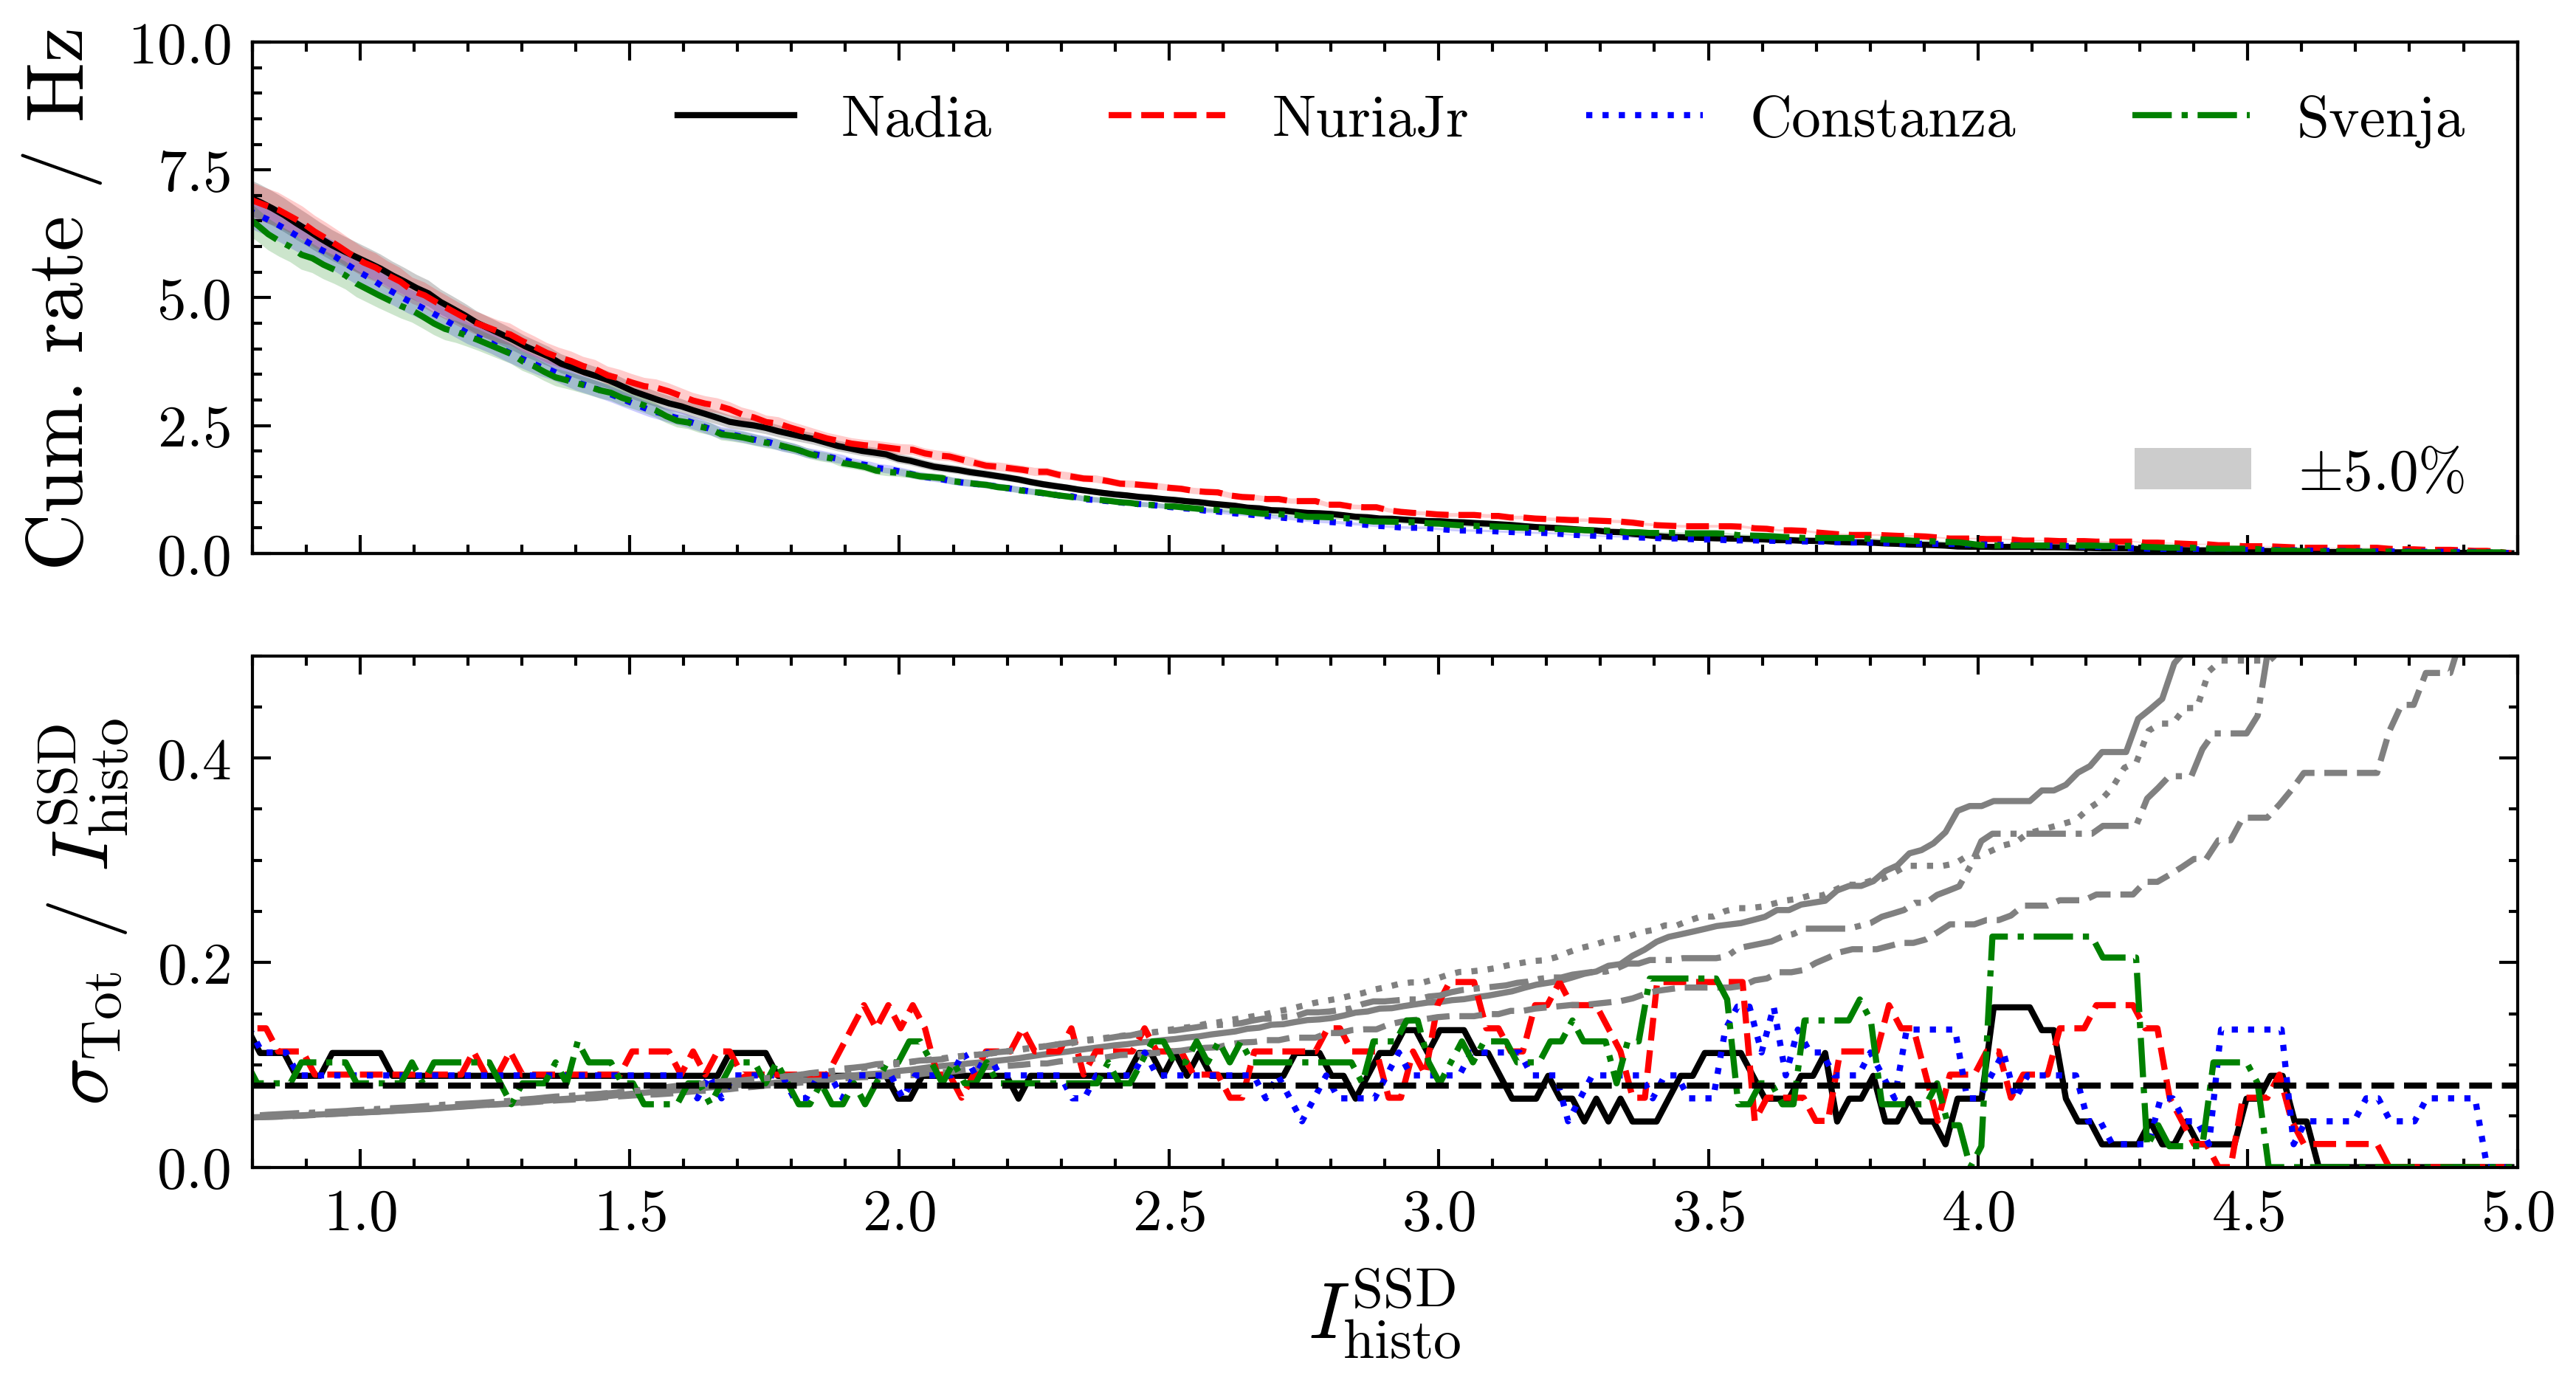

In [23]:
import os

base = '/cr/users/filip/Data/StationEfficiencies/'
MIP = {'Nadia':             44.8,
       'NuriaJr':           44.3,
       'Constanza' :        44.6,
       'Svenja' :           48.9}

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
to_integral_rate = lambda n, t :  np.cumsum(n[::-1])[::-1] / t
closest_index = lambda y1, y2 : np.argmin(np.abs(y1 - y2))
systematics = 0.05 #0.11649456521485056
t1_pre = True
DAQ = 61

for station in ['Nadia', 'NuriaJr', 'Constanza', 'Svenja']:

    date = '2023_03' if station in ['Nadia', 'Constanza'] else '2022_11'
    peaks = np.loadtxt(f'{base}/{station}_{"t1s" if t1_pre else "all"}.gz')
    DAQ_time = len(os.listdir(f'/cr/data02/AugerPrime/UUB/UubRandoms/{date}/{station}')) * 5000 * 2048 * 8.33e-9
    
    n, bins = np.histogram(peaks, bins=int(5 * MIP[station]), range=(0, 5 * MIP[station]))
    rates = to_integral_rate(n, DAQ_time)
    station_fluctuation = np.zeros_like(bins[1:])

    # rate correction factor
    observed_rates = np.loadtxt(f'/cr/data02/AugerPrime/UUB/UubRandoms/t1_rates/{station}.txt', usecols=[2])
    correction_factor = np.mean(observed_rates) / 100
    rates /= (correction_factor if t1_pre else 1)
    low, high = (1-systematics) * rates, (1+systematics) * rates

    for i, y in enumerate(rates):
        lower_bound = bins[closest_index(y, low)]
        upper_bound = bins[closest_index(y, high)]
        station_fluctuation[i] = (upper_bound - lower_bound) / MIP[station]

    X = 0.5 * (bins[1:] + bins[:-1]) / MIP[station]
    ax1.plot(X, rates, label=station)
    ax1.fill_between(X, low, high, alpha=0.2)

    total_error = np.sqrt(station_fluctuation**2 )#+ 1/(rates * DAQ))
    line = ax2.plot(X, total_error)
    ax2.plot(X, 1/np.sqrt(rates * DAQ), c='gray', ls=line[0].get_linestyle())

ax1.legend(ncols=4)
ax2.set_ylim(0, 1)
ax2.axhline(0.08, c='k', ls='--')

ax1_clone = ax1.twinx()
shade = ax1_clone.fill_between([], [], [], alpha=0.2, label=fr'$\pm${systematics*1e2:.1f}%')
ax1_clone.get_yaxis().set_visible(False)
ax1_clone.legend(loc='lower right')
# ax1.set_yscale('log')
# ax1.set_xlim(1, 5)
ax1.set_ylim(0, 10 if t1_pre else 400)
ax2.set_ylim(0, 0.5 if t1_pre else 0.25)
ax2.set_xlim(0.8, 5)

ax1.set_ylabel('Cum. rate / Hz')
ax2.set_ylabel(r'$\sigma_\mathrm{Tot}$ / $I^\mathrm{SSD}_\mathrm{histo}$')
ax2.set_xlabel('$I^\mathrm{SSD}_\mathrm{histo}$')
plt.savefig(f'/cr/users/filip/plots/total_errors_{"t1" if t1_pre else "_all"}.png', bbox_inches='tight')